In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jenkspy

In [8]:
# parsing
def parse_latency_and_time(filename):
    curr = open(filename, "r")
    mode = ""
    latencies = []
    times = []
    for line in curr.readlines():
        line = line.strip()
        if line == "LATENCY":
            mode = "L"
            continue
        elif line == "TIMES":
            mode = "T"
            continue
        if mode == "L":
            latencies.append(float(line))
        elif mode == "T":
            times.append(float(line))
    curr.close()
    return latencies, times


    



In [9]:
h264_latency, h264_time = parse_latency_and_time("h264-100.txt")
compressed_latency, compressed_time = parse_latency_and_time("compressed-100.txt")
print(compressed_latency)

[1894186900.5491729, 1894186929.130715, 1894186897.098382, 1894186911.826748, 1894186908.590397, 1894186912.3740208, 1894186923.652773, 1894186917.078096, 1894186891.24106, 1894186885.5204449, 1894186888.979583, 1894186888.903441, 1894186879.708647, 1894186870.308378, 1894186888.409488, 1894186878.011901, 1894186865.867053, 1894186886.5752409, 1894186897.438263, 1894186884.782742, 1894186903.8375268, 1894186887.1003559, 1894186859.534736, 1894186860.315502, 1894186856.570092, 1894186852.870669, 1894186856.653399, 1894186855.998551, 1894186858.326782, 1894186875.897847, 1894186858.905545, 1894186857.298292, 1894186868.3132, 1894186863.2086098, 1894186892.927085, 1894186881.667392, 1894186884.758544, 1894186891.3231459, 1894186858.975297, 1894186850.2375638, 1894186866.7748048, 1894186851.8392808, 1894186857.342356, 1894186842.457176, 1894186847.623354, 1894186853.0519788, 1894186842.583907, 1894186858.817122, 1894186842.2344909, 1894186852.0437138, 1894186854.1454408, 1894186844.937337,

In [38]:
def calculate_sigma(latencies, window=100):
        if len(latencies) <= 100:
            return
        return np.percentile(latencies[-100:], 68)
        
def goodness_of_variance_fit(array, classes):
    # get the break points
    classes = jenkspy.jenks_breaks(array, classes)

    # do the actual classification
    classified = np.array([classify(i, classes) for i in array])
    
    stat = 0
    
    separated_arrays = []
    
    for i in range(len(classes) - 1):
        idx = np.where(np.logical_and(array >= classes[i], array < classes[i+1]))
        separated_arrays.append(array[idx])

    for i in range(len(separated_arrays)-1, -1, -1):
        if len(separated_arrays[i]) / len(array) > 0.05:
            stat = np.mean(separated_arrays[i])
            break
        

    # max value of zones
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf, classes

def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1

def calculate_jitter(latencies):
    jitter = np.diff(latencies)
    avg_jitter = np.mean(np.abs(jitter))
    return avg_jitter

def plot_latency(latencies):
    # Ensure latencies are sorted for percentile calculations
    sorted_latencies = np.sort(latencies)

    # Calculate metrics
    mean = np.mean(latencies)
    median = np.median(latencies)
    std = np.std(latencies)
    p95 = np.percentile(sorted_latencies, 95)
    p99 = np.percentile(sorted_latencies, 99)
    min_latency = np.min(latencies)
    max_latency = np.max(latencies)
    
    # print("mean 85%+", np.mean(sorted_latencies[np.where(sorted_latencies >= np.percentile(sorted_latencies,85))]))
    
    gvf = 0.0
    for nclasses in [2, 3, 4, 5]:
        gvf, classes = goodness_of_variance_fit(np.array(latencies), nclasses)
        if gvf > 0.9:
            break
        # print('gvf:', gvf)
        # print('ncl', nclasses)
        
    # Plot the raw latencies
    # plt.hist(sorted_latencies, bins=40)
    plt.hist(sorted_latencies)
    print(sorted_latencies)
    
    # for d in classes:
    #     plt.axvline(x=d, color='r')
    
    # Plot metrics
    # plt.axhline(y=mean, color='r', linestyle='-', label=f'Mean: {mean:.2f},' + f'StD: {std:.2f}')
    # plt.axhline(y=median, color='g', linestyle='-', label=f'Median: {median:.2f}')
    # plt.axhline(y=p95, color='y', linestyle='-', label=f'95th percentile: {p95:.2f}')
    # plt.axhline(y=p99, color='m', linestyle='-', label=f'99th percentile: {p99:.2f}')
    # plt.axhline(y=min_latency, color='c', linestyle='-', label=f'Min: {min_latency:.2f}')
    # plt.axhline(y=max_latency, color='b', linestyle='-', label=f'Max: {max_latency:.2f}')

    # Setting labels and legend
    plt.title("Latency Distribution")
    plt.xlabel("Latency")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
def plot_latency_over_time(timestamps, latencies):
    # Ensure latencies are sorted based on timestamps
    # sorted_indices = np.argsort(timestamps)
    # sorted_latencies = np.array(latencies)[sorted_indices]
    # sorted_timestamps = np.array(timestamps)[sorted_indices]
    nanoseconds_constant = 1e-6

    
    sorted_latencies = np.array(latencies) / nanoseconds_constant
    sorted_timestamps = np.array(timestamps) / nanoseconds_constant

    print(latencies[:20], np.array(latencies)[:20])


    
    # Calculate metrics
    mean = np.mean(sorted_latencies)
    median = np.median(sorted_latencies)
    std = np.std(sorted_latencies)
    p95 = np.percentile(sorted_latencies, 95)
    p99 = np.percentile(sorted_latencies, 99)
    min_latency = np.min(sorted_latencies)
    max_latency = np.max(sorted_latencies)

    # Plot the raw latencies over time
    
    plt.plot(sorted_timestamps, sorted_latencies, color='blue', label="Latencies", linestyle='-')

    # Plot metrics
    plt.axhline(y=mean, color='r', linestyle='-', label=f'Mean: {mean:.2f},' + f'StD: {std:.2f}')
    plt.axhline(y=median, color='g', linestyle='-', label=f'Median: {median:.2f}')
    plt.axhline(y=p95, color='y', linestyle='-', label=f'95th percentile: {p95:.2f}')
    plt.axhline(y=p99, color='m', linestyle='-', label=f'99th percentile: {p99:.2f}')
    plt.axhline(y=min_latency, color='c', linestyle='-', label=f'Min: {min_latency:.2f}')
    plt.axhline(y=max_latency, color='b', linestyle='-', label=f'Max: {max_latency:.2f}')

    # Setting labels, legend, and formatting
    plt.title("Latency Distribution Over Time")
    plt.xlabel("Time")
    plt.ylabel("Latency")
    # plt.xticks(rotation=45)
    #plt.tight_layout()
    plt.legend()
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.show()


[1692158374.155148, 1692158406.337394, 1692158374.985451, 1692158361.977901, 1692158349.0307, 1692158327.741767, 1692158359.751674, 1692158360.882453, 1692158354.272692, 1692158364.937031, 1692158341.529567, 1692158354.52406, 1692158357.12151, 1692158373.852509, 1692158400.494361, 1692158384.088811, 1692158379.5803099, 1692158363.7603688, 1692158366.407954, 1692158356.49137] [1.69215837e+09 1.69215841e+09 1.69215837e+09 1.69215836e+09
 1.69215835e+09 1.69215833e+09 1.69215836e+09 1.69215836e+09
 1.69215835e+09 1.69215836e+09 1.69215834e+09 1.69215835e+09
 1.69215836e+09 1.69215837e+09 1.69215840e+09 1.69215838e+09
 1.69215838e+09 1.69215836e+09 1.69215837e+09 1.69215836e+09]


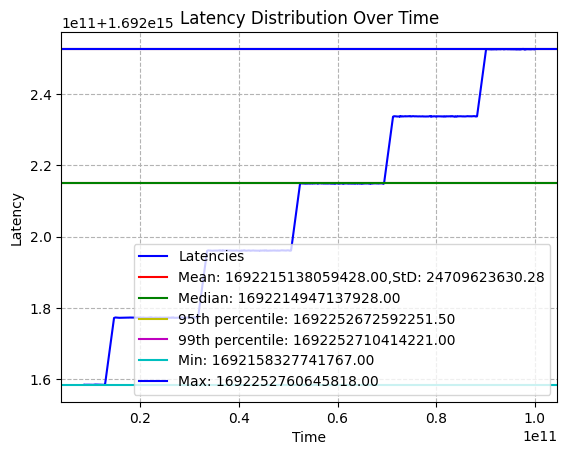

In [39]:
# plot_latency(np.array(h264_latency))
plot_latency_over_time(h264_time, h264_latency)